## Import Dependencies

In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
# from datetime import datetime
from datetime import datetime, timedelta

# Data Visualization Libraries:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Import data

In [2]:
# import data using read_csv() method for 
# Phase 1: Baseline KPI analysis
customers = pd.read_csv("static/data/customers.csv")
purchases = pd.read_csv("static/data/in_app_purchases.csv")

# Phase 2: A/B testing phase
revenue = pd.read_csv("static/data/revenue.csv")
paywall_demo = pd.read_csv("static/data/user_demographics_paywall.csv")

# Phase 3: A/B testing analyis
ab_results = pd.read_csv("static/data/ab_testing_results.csv")

## Examine customer and app purchase information
 - datasets: customers and purchases
 - determine baseline key peformance index (converstion rates)
 - develop A/B plan: sample size, power, etc
 - analyze results
 - determine if campaign was successful

### Data wranging

In [3]:
# Examine datatypes
print(purchases.info())
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9006 entries, 0 to 9005
Data columns (total 4 columns):
date     9006 non-null object
uid      9006 non-null int64
sku      9006 non-null object
price    9006 non-null int64
dtypes: int64(2), object(2)
memory usage: 281.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
uid         10000 non-null float64
reg_date    10000 non-null object
device      10000 non-null object
gender      10000 non-null object
country     10000 non-null object
age         10000 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB
None


### Change datatypes
 - df['col'] = df['col'].astype('datetime64[ns]') 
 - df[col] = df[col].astype('category')

In [4]:
# Rename column date in the customers df
customers.columns = ['date' if x=='reg_date' else x for x in customers.columns]

In [5]:
# Convert price to currency format (without the $ sign as this would change it to a string object)
purchases['price'] = purchases['price'].apply(lambda x: '{:.2f}'.format((x/100)))
purchases['price'] = purchases['price'].astype('float')

In [6]:
# Change date columns from objects to datetime
purchases['date'] = purchases['date'].astype('datetime64[ns]')
customers["date"] = customers["date"].astype('datetime64[ns]')

In [7]:
# Rename values in the device feature of customers
customers['device'].replace({'and':'android'}, inplace= True)
# Update country names in the customers df
customers['country'].replace({'BRA':'Brazil', 'CAN':'Canada', 'DEU': 'Germany', 'FRA':'France', 'TUR':'Turkey'}, inplace= True)

In [8]:
# Change columns where unique values < 10 to category
purchases["sku"] = purchases["sku"].astype('category')
# Use a .apply() to change multiple columns in the customers df
customer_cols = ['device', 'gender', 'country']
customers[customer_cols] = customers[customer_cols].apply(lambda x: x.astype('category'))

In [9]:
# Confirm datatype changes
print(purchases.info())
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9006 entries, 0 to 9005
Data columns (total 4 columns):
date     9006 non-null datetime64[ns]
uid      9006 non-null int64
sku      9006 non-null category
price    9006 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 220.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
uid        10000 non-null float64
date       10000 non-null datetime64[ns]
device     10000 non-null category
gender     10000 non-null category
country    10000 non-null category
age        10000 non-null int64
dtypes: category(3), datetime64[ns](1), float64(1), int64(1)
memory usage: 264.2 KB
None


### First Subset: <font color="red">customer_purchases</font> purchases and customers merged using .merge()

In [10]:
# Merge on the 'uid' and 'date' field
customer_purchases = purchases.merge(customers, on=['uid'], how='inner')

In [11]:
# Examine the results 
print(customer_purchases.head())
print(f'The number of observations in the dataset is: {len(customer_purchases)}')

      date_x       uid            sku  price     date_y   device gender  \
0 2017-07-10  41195147  sku_three_499   4.99 2017-06-26  android      M   
1 2017-07-15  41195147  sku_three_499   4.99 2017-06-26  android      M   
2 2017-11-12  41195147   sku_four_599   5.99 2017-06-26  android      M   
3 2017-09-26  91591874    sku_two_299   2.99 2017-01-05  android      M   
4 2017-12-01  91591874   sku_four_599   5.99 2017-01-05  android      M   

  country  age  
0  Brazil   17  
1  Brazil   17  
2  Brazil   17  
3  Turkey   17  
4  Turkey   17  
The number of observations in the dataset is: 9006


## Baseline PRICE EDA Key performance index (KPI)
- Price by country : What is the median price spent
- Age by country: what is the median age of customers
- Gender by country: what is the male/female customer ration by country
- Device by country: what devices are used by country
- Sku by country: which products are popular

### Distribution of purchases by price stratified by Country, Age, and Gender

### Distribution of purchases by price by Country

In [30]:
customer_purchases.groupby('country')["price"].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Brazil,2694.0,4.098389,1.915050,0.99,2.99,4.99,5.99,8.99
Canada,399.0,3.982481,1.858687,0.99,1.99,2.99,5.49,8.99
France,544.0,4.017574,1.863968,0.99,1.99,2.99,4.99,8.99
Germany,915.0,4.090546,1.782098,0.99,2.99,4.99,4.99,8.99
Turkey,804.0,4.154179,1.938766,0.99,2.99,4.99,5.99,8.99
USA,3650.0,4.037123,1.867339,0.99,2.99,2.99,4.99,8.99


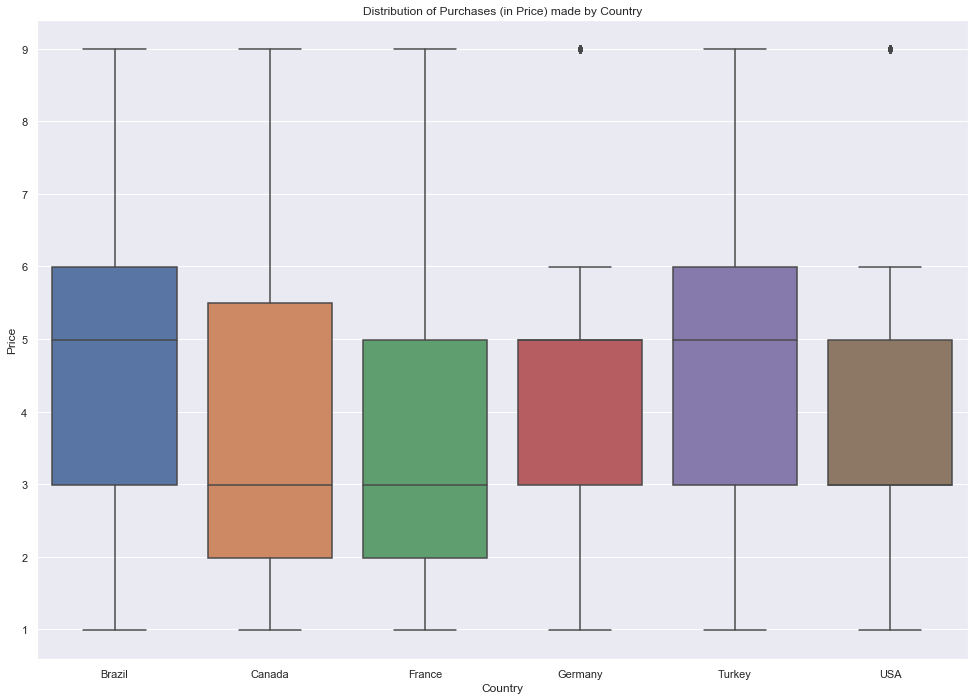

In [31]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 22})
ax = sns.boxplot(x="country", y="price", data=customer_purchases)    
plt.tight_layout()
plt.ylabel("Price")
plt.xlabel("Country")
plt.title("Distribution of Purchases (in Price) made by Country")
plt.savefig("static/images/plot_box_purchases_country_price.png", bbox_inches='tight')
plt.show()

Brazil and Turkey make the highest median purchases than other countries
France and Canda made the lowest median purchases than other countries

### Customer Ages by Country

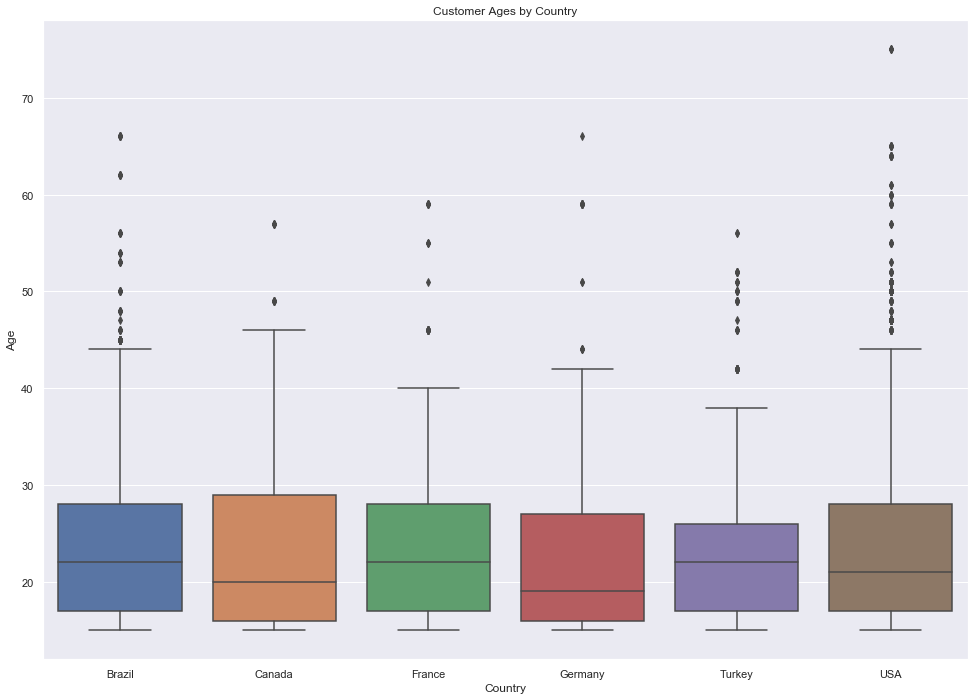

In [32]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 22})
ax = sns.boxplot(x="country", y="age", data=customer_purchases)    
plt.tight_layout()
plt.ylabel("Age")
plt.xlabel("Country")
plt.title("Customer Ages by Country")
plt.savefig("static/images/plot_box_ages_country.png", bbox_inches='tight')
plt.show()

Customers in France have the highest median age, while Germany has the youngest customers.
Most customers appear to be under 30 years of age.

### Gender by country

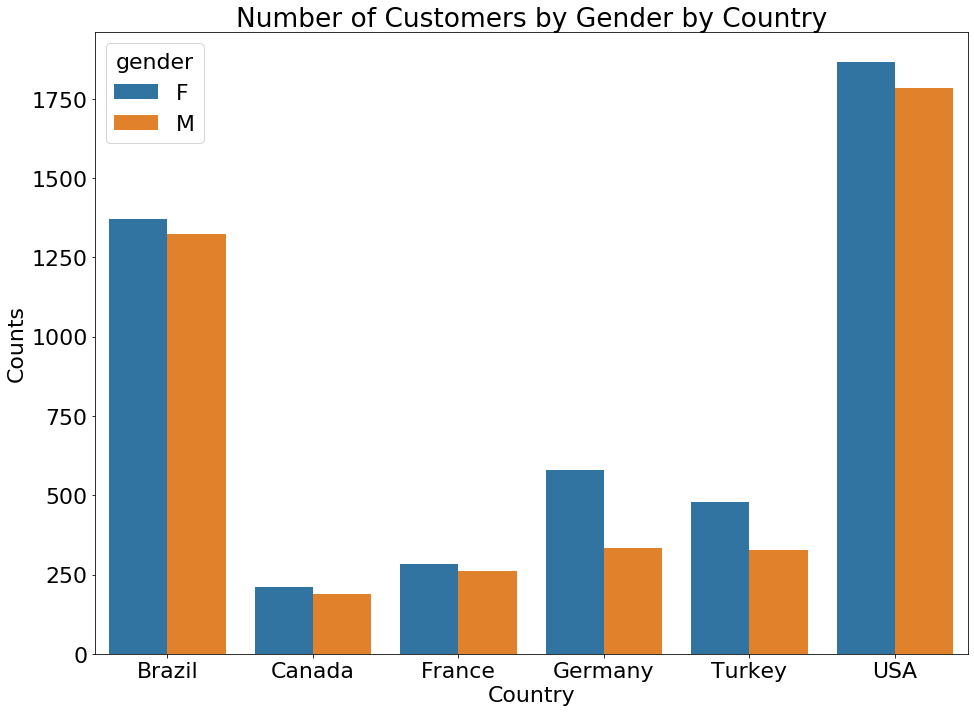

In [14]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 22})
ax = sns.countplot(x="country", hue="gender", data=customer_purchases)
plt.tight_layout()
plt.ylabel("Counts")
plt.xlabel("Country")
plt.title("Number of Customers by Gender by Country")
plt.savefig("static/images/plot_count_gender_country.png", bbox_inches='tight')
plt.show()

There are more female customers than male customers.

### Devices used by country

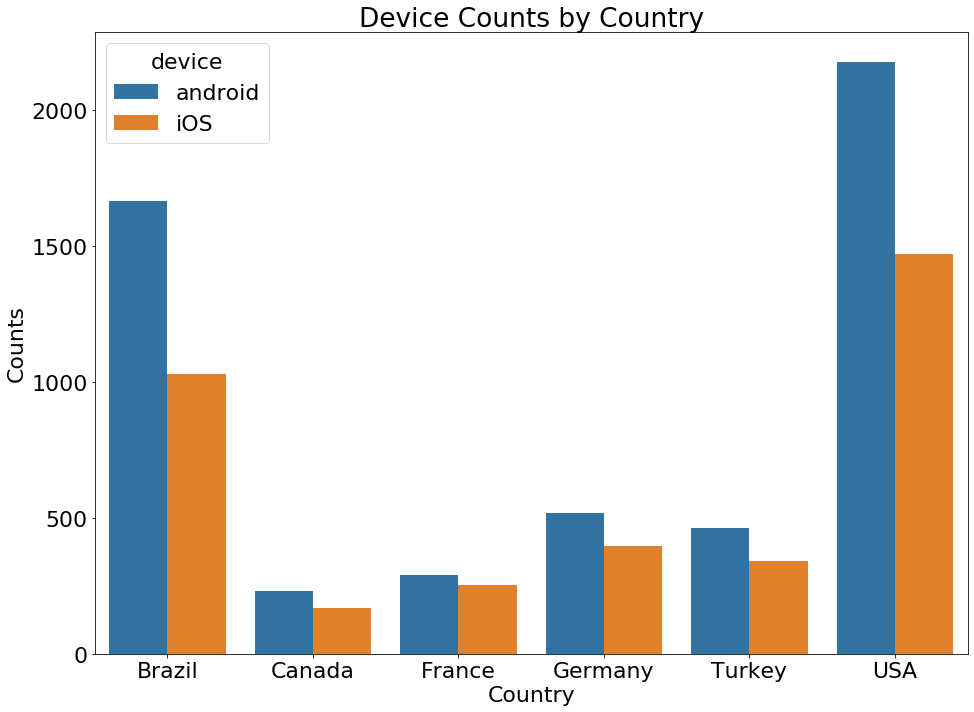

In [15]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 22})
ax = sns.countplot(x="country", hue="device", data=customer_purchases)
plt.tight_layout()
plt.ylabel("Counts")
plt.xlabel("Country")
plt.title("Device Counts by Country")
plt.savefig("static/images/plot_count_device_country.png", bbox_inches='tight')
plt.show()

Android is the dominant device type for all countries.

### Product mix sales by country

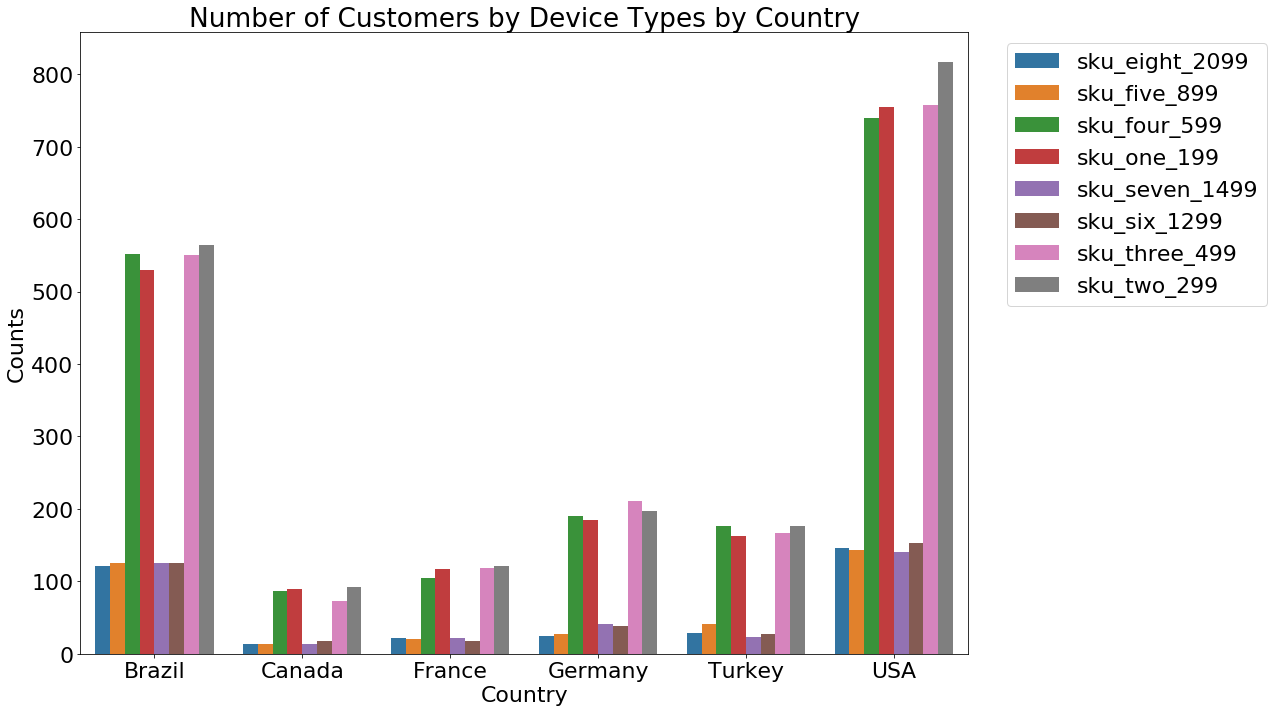

In [16]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 22})
ax = sns.countplot(x="country", hue="sku", data=customer_purchases)
plt.tight_layout()
plt.ylabel("Counts")
plt.xlabel("Country")
plt.title("Number of Customers by Device Types by Country")
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1), ncol=1)
plt.savefig("static/images/plot_count_sku_country.png", bbox_inches='tight')
plt.show()

The top 4 products for all countries are: sku_four_599, sku_one_199, sku_three_499, sku_two_299.
Brazil has a higher proportion of their customers that purchase sku_eight_2099, and sku_five_899 than other countries. This may account for the higher median sale of prices.

## Baseline Price EDA with 3-variable Segmentation
- Price by country and gender
- Price by country and age
- Price by country and device
- Price by country and sku
- sku counts by country and gender (stacked bar plot)

### Price by country and gender

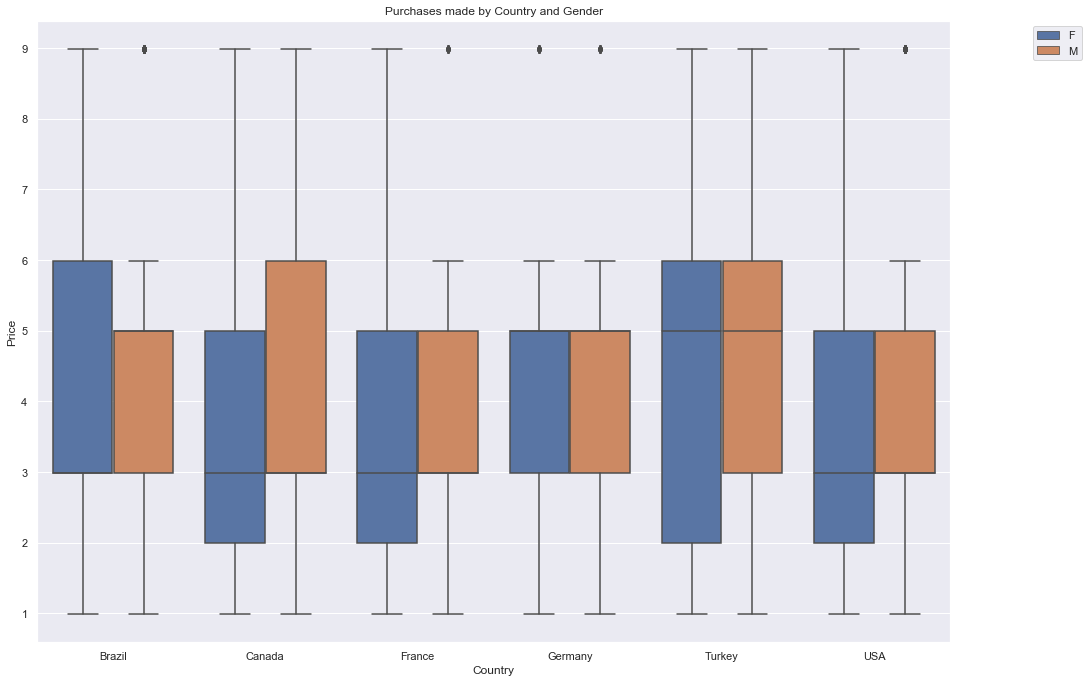

In [35]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 30})
ax = sns.boxplot(x="country", y="price", hue="gender", data=customer_purchases) 
plt.tight_layout()
plt.ylabel("Price")
plt.xlabel("Country")
plt.title("Purchases made by Country and Gender")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig("static/images/plot_box_customer_purchases_country_price_gender.png", bbox_inches='tight')
plt.show()

In all countries, but Brazil, males make higher median purchases by price than females.

Men in France spent more than other countries, while men in Canada spent the least.

Bottomline: All there are more female customers by country, males are making bigger purchases than females in all but Brazil.

### Price by country and age

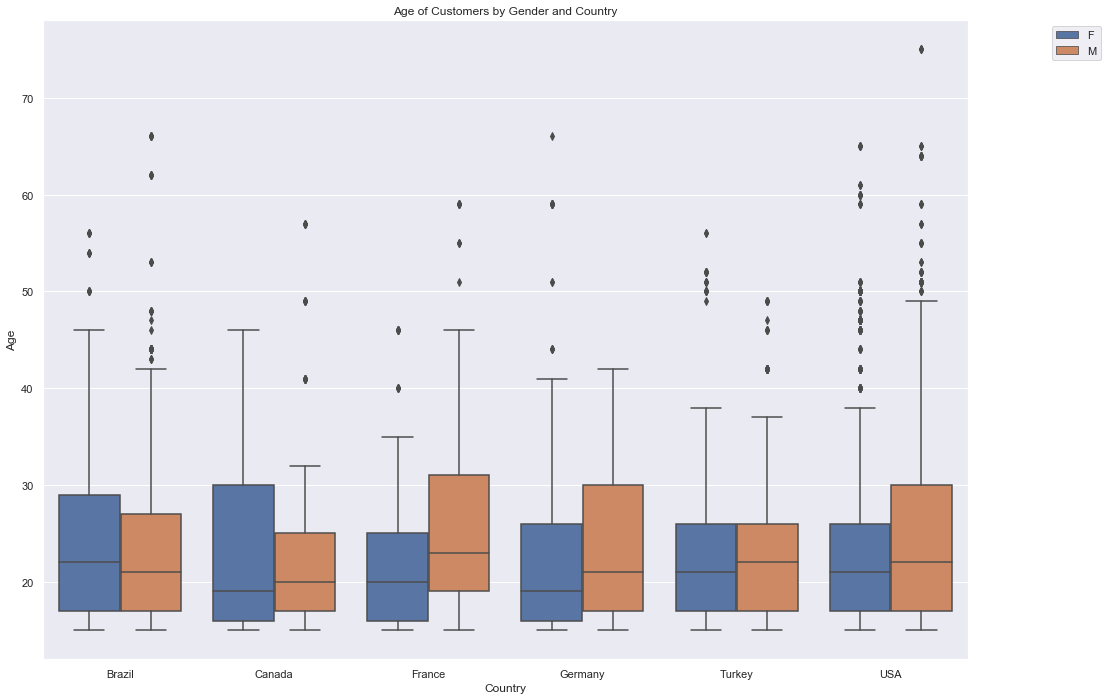

In [36]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 22})
ax = sns.boxplot(x="country", y="age", hue="gender", data=customer_purchases)    
plt.tight_layout()
plt.ylabel("Age")
plt.xlabel("Country")
plt.title("Age of Customers by Gender and Country")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)
plt.savefig("static/images/plot_box_customer_purchases_country_price_age.png", bbox_inches='tight')
plt.show()

Men are generally older than females in all countried but brazil.

### Price by country and device

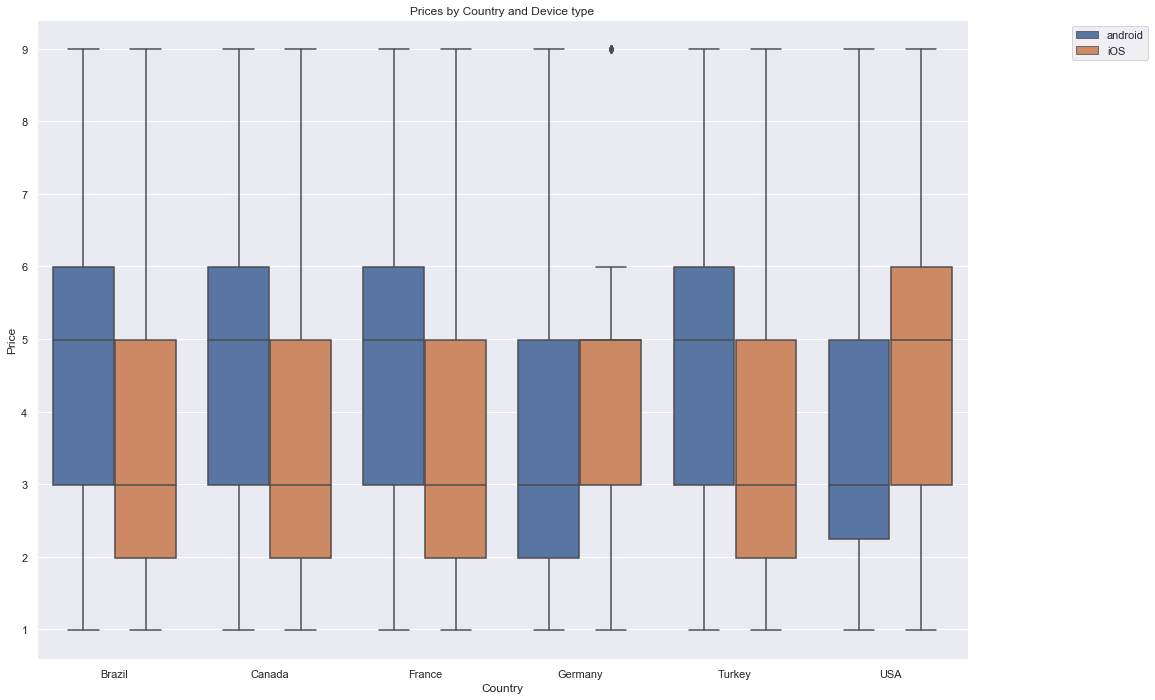

In [37]:
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 22})
ax = sns.boxplot(x="country", y="price", hue="device", data=customer_purchases)    
plt.tight_layout()
plt.ylabel("Price")
plt.xlabel("Country")
plt.title("Prices by Country and Device type")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1)
plt.savefig("static/images/plot_box_customer_purchases_country_price_device.png", bbox_inches='tight')
plt.show()

Higher purchases are made in Android devices in all countries but Germany and the US, where iOS is higher.

### Price by gender, country and device

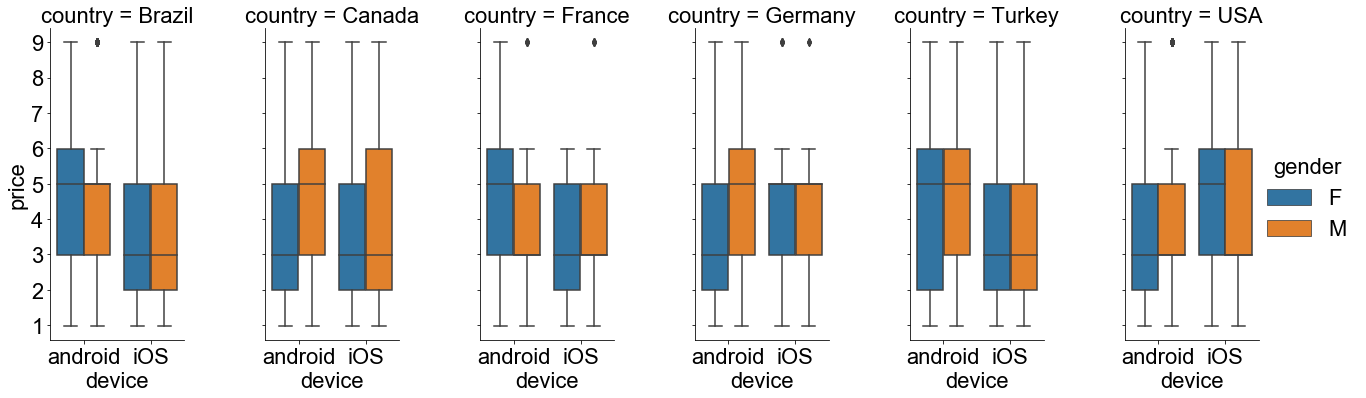

In [20]:
g = sns.catplot(x="device", y="price",
                hue="gender", col="country",
                data=customer_purchases, kind="box",
                height=6, aspect=.5);
sns.set(rc={'figure.figsize':(10,20)})
plt.savefig("static/images/plot_catplot_customer_purchases_country_price_gender.png", bbox_inches='tight')
plt.show()

### Price by country, gender and kpu

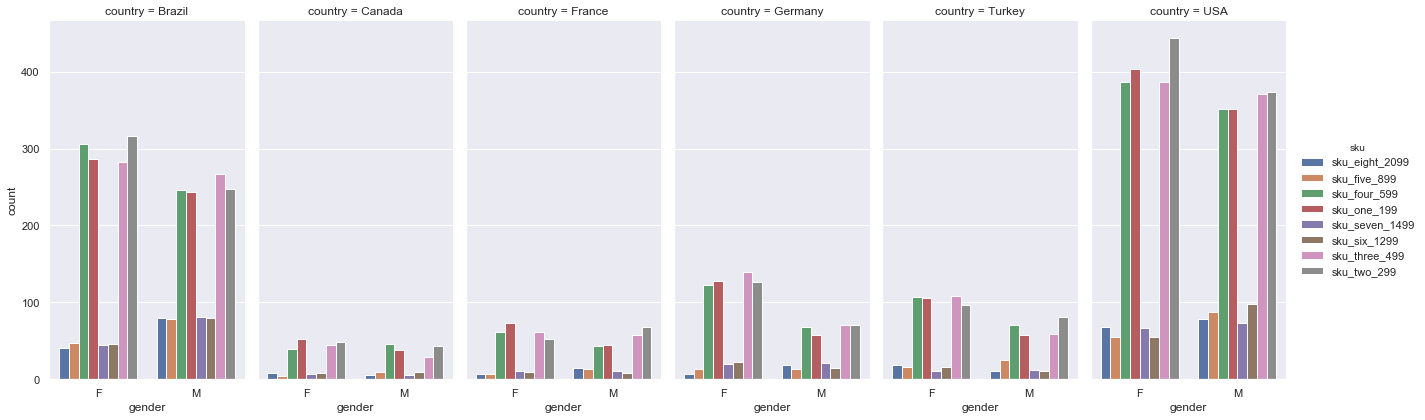

In [21]:
g = sns.catplot(x="gender",
                hue="sku", col="country",
                data=customer_purchases, kind="count",
                height=6, aspect=.5)
sns.set(rc={'figure.figsize':(10,20)})
# plt.savefig("static/images/plot_catplot_customer_purchases_country_price_gender.png", bbox_inches='tight')
plt.show()

In [22]:
# Use the pivot_table method to plot the mix of products purchased by country and by gender
sku_counts_by_gender_country = pd.pivot_table(customer_purchases, values='price', index=['country', 'gender'], columns=['sku'], aggfunc='count')

In [23]:
# Counts as a Proportion
sku_proportion_by_gender_country = sku_counts_by_gender_country.div(sku_counts_by_gender_country.sum(axis=1), axis=0)

### Proportion of Product mix sales by country and gender

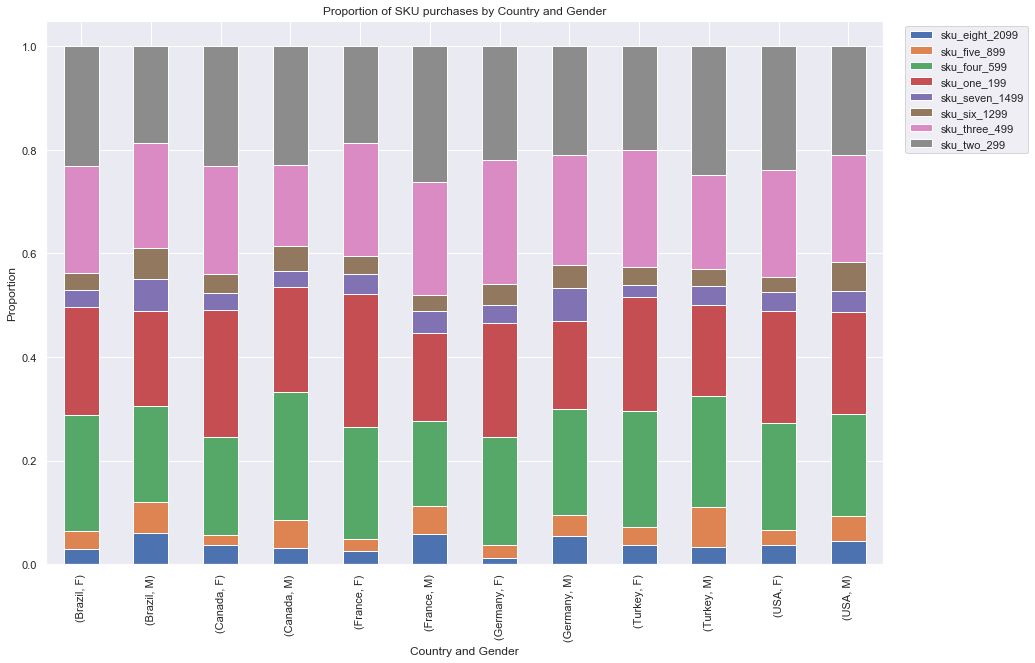

In [50]:
ax = sku_proportion_by_gender_country.plot.bar(stacked=True, figsize=(15,10))
plt.ylabel("Proportion")
plt.xlabel("Country and Gender")
plt.title("Proportion of SKU purchases by Country and Gender")
plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1), ncol=1)
plt.savefig("static/images/plot_stacked_bar_sku_purchases_country_price_gender.png", bbox_inches='tight')
plt.show()

## Examine baseline KPI  "purchases" using groupby
 - dataset: customer_purchases
 - sort values by price, then groupby, and then review summary

In [25]:
country_device_subset = customer_purchases.groupby(by=['country'], axis=0, as_index=False)

Evaluate the purchasing behaviors by country and speficially:
 - total transactions in this period
 - the sum of these transactions
 - the mean purchase by country
 - the median purchase by country
 - the standard deviation by country
 - the min purchase made (dollars)
 - the max purchase made (dollars)
 - the mean, and median age of purchases
 - the youngest and oldest customer

In [26]:
# Create a dictionary that will be used to aggregate the groupby object
func_dic = {'price': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max'], 
            'age': ['mean','median', 'std', 'min', 'max']}
# Apply the dictionary, reset the index, assign to a new variable, and sort values by 
# the multi-level indexusing a tuple
grouped = country_device_subset.agg(func_dic).reset_index(drop=True)
grouped.sort_values(('price', 'count'), ascending=False).style.hide_index()

### Summary of results
 - USA had the highest number of purchases in terms of counts, and sum, made lots of smaller purchases (how can we get them to buy higher priced products?)
 - Brazil was the 2nd highest country with transaction counts although Brazil had higher mean purchases than US customers (some of these purchases were higher priced products)
 - Turkey had the highest mean purchases (they had fewer transactions, but spent more per transaction)
 - Canada has the lowest customer purchases in counts, sum, mean, median
 
Customer Age Demographics
 - USA had the oldest mean age customers
 - Brazil had the oldest median age
 - Germany had the youngest mean and median customers

### Examine KPI "conversion rate" a week after the free trial ends
 - dataset: need to create a dataframe that has subscription data

Will need to add a column to show their lapse_date (the amount of time between the date they joined the app, and the time they made their first purchase)
 - some uid's have > 1 purchase
 - min('date_y') - customer(join date)
 
 will need a dataframe that has:
 - uid
 - join date
 - date of first purchase (will need to subset the purchase dataframe

### Create dataframe for subscription dates

In [38]:
# Create a pandas.core.series.Series that contains unique id and first purchase
sub_dates = purchases.groupby('uid')['date'].min()

In [39]:
# Create dataframe and rename columns
subscription_date_df = pd.DataFrame(sub_dates).reset_index()
subscription_date_df.columns = ['sub_date' if x=='date' else x for x in subscription_date_df.columns]

In [40]:
# Merge on the 'uid' and 'date' field
customer_subscriptions = subscription_date_df.merge(customers, on=['uid'], how='inner')
# Rename column
customer_subscriptions.columns = ['join_date' if x=='date' else x for x in customer_subscriptions.columns]

In [41]:
# Feature engineering: add a column that has the time lapse between 
# The date they joined the app, to the day they made their first purchase
customer_subscriptions["lapse_time"] = customer_subscriptions["sub_date"] - customer_subscriptions["join_date"]

In [42]:
# Reorder columns
customer_subscriptions = customer_subscriptions[["uid", "join_date", "sub_date", "lapse_time", "device", "gender", "gender", "age", "country"]]

In [ ]:
# Save file to csv
customer_subscriptions.to_csv('static/data/subscription_dates.csv', index=False)

In [43]:
current_date = pd.to_datetime('2018-03-17')

In [44]:
# What is the maximum lapse date in our data
print(customer_subscriptions.lapse_date.max())

AttributeError: 'DataFrame' object has no attribute 'lapse_date'